In [1]:
from scipy.sparse.linalg import lsmr
from scipy.optimize import lsq_linear
from scipy.optimize import nnls
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


epsilon = 1/5 # Rate of progression from exposed to infectious (the reciprocal is the incubation period)
gamma = 1/14 # Recovery rate of infectious individuals (the reciprocal is the infectious period)    

In [2]:
df = pd.read_csv('covid19casesdemographics.csv')

In [3]:
age_df = df[df['demographic_category']== 'Age Group']

In [4]:
age_df['demographic_value'].unique()

array(['0-17', '18-49', '50-64', '65+', 'Missing', 'Total', 'missing'],
      dtype=object)

In [5]:
age_df = age_df[age_df.demographic_value.isin(['0-17', '18-49', '50-64', '65+'])]

In [6]:
#California population obtained from google
Population = 39000000
Days = len(age_df['report_date'].unique())

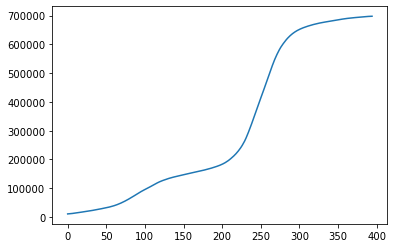

In [7]:
#obtain Infected data
ages = ['0-17', '18-49', '50-64', '65+']

Inf = dict()
for i in ages:
    age_group = age_df[age_df['demographic_value'] == i]
    Ii = []
    for k in range(0, 30):
        Ii.append(age_group['total_cases'].iloc[0])       #pad the front of signal
    for k in range(0, Days):
        Ii.append(age_group['total_cases'].iloc[k])
    for k in range(0, 30):
        Ii.append(age_group['total_cases'].iloc[Days-1])  #pad the end of signal 
    Ii = np.convolve(Ii, np.ones(15)/15, mode='same') #moving average filter 20 length
    Inf[i] = Ii[30:Days+30] #remove padding
    
plt.plot(range(Days),Inf['50-64'])

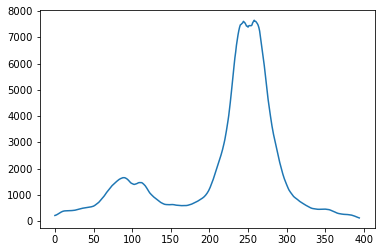

In [8]:
#Derive daily new infection 
newinf = dict()
for i in ages:
    temp = []
    for k in range(0, 30):
        temp.append(Inf[i][1]-Inf[i][0])
    temp.append(Inf[i][1]-Inf[i][0])
    for k in range(1, Days):
        temp.append(Inf[i][k]-Inf[i][k-1])
    for k in range(0, 30):
        temp.append(Inf[i][Days-1]-Inf[i][Days-2])
    temp = np.convolve(temp, np.ones(10)/10, mode='same')
    newinf[i] = temp[30:Days+30]
   
plt.plot(range(Days),newinf['50-64'])


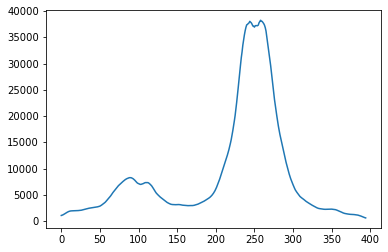

In [9]:
#Derive exposed E[n] 
incubation_days = 5

E = dict()
for i in ages:
    temp = []
    for k in range(Days):
        temp.append(newinf[i][k]*incubation_days)
    E[i] = temp
plt.plot(range(Days),E['50-64'])
    

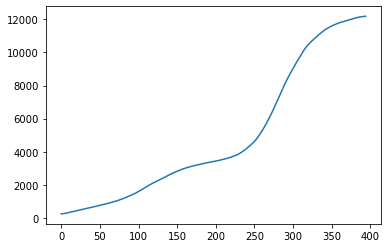

In [10]:
#obtain Death data D[n]

ages = ['0-17', '18-49', '50-64', '65+']

D = dict()
for i in ages:
    age_group = age_df[age_df['demographic_value'] == i]
    Ii = []
    for k in range(0, 30):
        Ii.append(age_group['deaths'].iloc[0])       #pad the front of signal
    for k in range(0, Days):
        Ii.append(age_group['deaths'].iloc[k])
    for k in range(0, 30):
        Ii.append(age_group['deaths'].iloc[Days-1])  #pad the end of signal 
    Ii = np.convolve(Ii, np.ones(15)/15, mode='same') #moving average filter 20 length
    D[i] = Ii[30:Days+30] #remove padding
    

plt.plot(range(Days),D['50-64'])


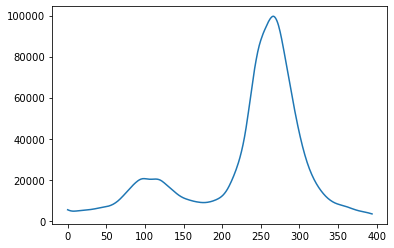

In [11]:
#derive infectious data I[n]
#Assume I[0] = 0.5*Inf[0]

I = dict()
for i in ages:
    temp = []
    temp.append(Inf[i][0]*0.5)
    for k in range(1,Days):
        temp.append(temp[k-1]+newinf[i][k-1]-gamma*temp[k-1])
    I[i] = temp
plt.plot(range(Days),I['50-64'])

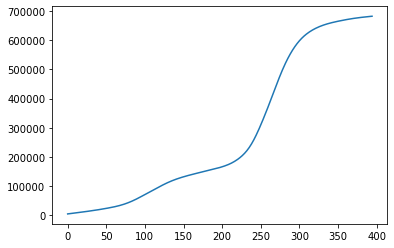

In [12]:
#derive Recovered data R[n]
R = dict()
for i in ages:
    temp = []
    temp.append(Inf[i][0]*0.5)
    for k in range(1,Days):
        temp.append(temp[k-1]+gamma*I[i][k-1])
    temp = temp-D[i]
    R[i] = temp
plt.plot(range(Days),R['50-64'])

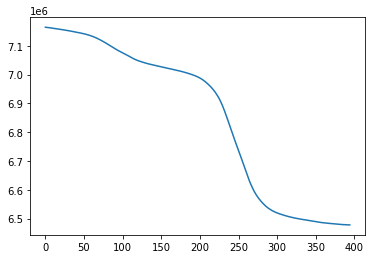

In [13]:
#obtain Susceptible data
percentages = age_df['percent_of_ca_population'].unique()
age_pop = dict(zip(ages, percentages))

S = dict()
for age in ages:
    Si = []
    for i, j, k, m in zip(E[age], I[age], R[age], D[age]):
        Si.append(age_pop[age]*Population/100-i-j-k-m)
    S[age] = Si
plt.plot(range(len(S['50-64'])),S['50-64'])

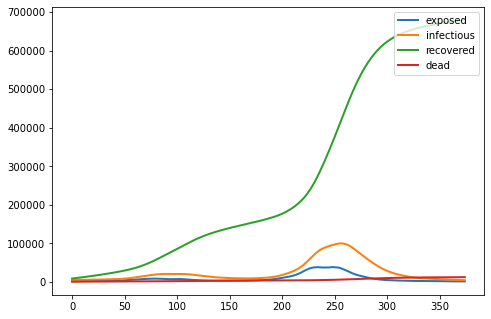

In [14]:
#truncate sequences and plot SEIR from data

for i in ages:
    S[i] = S[i][10:Days-10]
    E[i] = E[i][10:Days-10]
    I[i] = I[i][10:Days-10]
    R[i] = R[i][10:Days-10]
    D[i] = D[i][10:Days-10]
    Inf[i] = Inf[i][10:Days-10]
Days = Days-20

fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
#ax.plot(range(len(S['50-64'])),S['50-64'],lw=2,label='suceptible')
ax.plot(range(Days),E['50-64'],lw=2,label='exposed')
ax.plot(range(Days),I['50-64'],lw=2,label='infectious')
ax.plot(range(Days),R['50-64'],lw=2,label='recovered')
ax.plot(range(Days),D['50-64'],lw=2,label='dead')
#ax.set_ylabel(‘Price’,fontsize=20)
plt.legend(loc='upper right')

In [15]:
ages = ['0-17', '18-49', '50-64', '65+']
labels = ['1','2','3','4']
for i in range(0,4):
    vars()['S_'+labels[i]] = S[ages[i]]
    vars()['E_'+labels[i]] = E[ages[i]]
    vars()['I_'+labels[i]] = I[ages[i]]
    vars()['R_'+labels[i]] = R[ages[i]]
    vars()['D_'+labels[i]] = D[ages[i]]
    
N = []
for k in range(0, Days):
    Ni = 0
    for i in ages:
        Ni = Ni + S[i][k]+E[i][k]+I[i][k]+R[i][k]
    N.append(Ni)
#plt.plot(range(len(N)),N)

epsilon = 1/5 # Rate of progression from exposed to infectious (the reciprocal is the incubation period)
gamma = 1/14 # Recovery rate of infectious individuals (the reciprocal is the infectious period)    

In [16]:

segment_size = 10
A_1 = np.ndarray(shape=(0,4))
for i in range(0,Days-1,segment_size):
    C_1 = np.ndarray(shape=(0,4))
    d_1 = np.ndarray(shape=(0,1))
    for t in range(i, i+segment_size):
        if(t<Days-1):
            c = [[-S_1[t]*I_1[t]/N[t], -S_1[t]*I_2[t]/N[t], -S_1[t]*I_3[t]/N[t], -S_1[t]*I_4[t]/N[t]],
                [S_1[t]*I_1[t]/N[t], S_1[t]*I_2[t]/N[t], S_1[t]*I_3[t]/N[t], S_1[t]*I_4[t]/N[t]]]
            C_1=np.append(C_1,c,axis = 0)

            partial_d = [[S_1[t+1]-S_1[t]], [E_1[t+1]-E_1[t]+epsilon*E_1[t]]]
            d_1=np.append(d_1,partial_d,axis = 0)
    d_1=np.squeeze(d_1)
    x = np.ndarray(shape=(1,4))
    x[0] = lsq_linear(C_1, d_1, bounds=(0, np.inf))['x']

    A_1 = np.append(A_1,x,axis = 0)
#print(A_1)

alpha_1 = np.ndarray(shape=(1,1))
C_1 = np.ndarray(shape=(0,1))
d_1 = np.ndarray(shape=(0,1))
for t in range(0,Days-1):
    c = [[I_1[t]]]
    C_1=np.append(C_1,c,axis = 0)
    d = [[D_1[t+1]-D_1[t]]]
    d_1=np.append(d_1,d,axis = 0)
d_1=np.squeeze(d_1)
alpha_1[0] = lsq_linear(C_1, d_1, bounds=(0, np.inf))['x']
#print(alpha_1)

#print("===============================================")
A_2 = np.ndarray(shape=(0,4))
for i in range(0,Days-1,segment_size):
    C_1 = np.ndarray(shape=(0,4))
    d_1 = np.ndarray(shape=(0,1))
    for t in range(i, i+segment_size):
        if(t<Days-1):
            c = [[-S_2[t]*I_1[t]/N[t], -S_2[t]*I_2[t]/N[t], -S_2[t]*I_3[t]/N[t], -S_2[t]*I_4[t]/N[t]],
                [S_2[t]*I_1[t]/N[t], S_2[t]*I_2[t]/N[t], S_2[t]*I_3[t]/N[t], S_2[t]*I_4[t]/N[t]]]
            C_1=np.append(C_1,c,axis = 0)

            partial_d = [[S_2[t+1]-S_2[t]], [E_2[t+1]-E_2[t]+epsilon*E_2[t]]]
            d_1=np.append(d_1,partial_d,axis = 0)
    d_1=np.squeeze(d_1)
    x = np.ndarray(shape=(1,4))
    x[0] = lsq_linear(C_1, d_1, bounds=(0, np.inf))['x']

    A_2 = np.append(A_2,x,axis = 0)
#print(A_2)

alpha_2 = np.ndarray(shape=(1,1))
C_1 = np.ndarray(shape=(0,1))
d_1 = np.ndarray(shape=(0,1))
for t in range(0,Days-1):
    c = [[I_2[t]]]
    C_1=np.append(C_1,c,axis = 0)
    d = [[D_2[t+1]-D_2[t]]]
    d_1=np.append(d_1,d,axis = 0)
d_1=np.squeeze(d_1)
x = np.ndarray(shape=(1,1))
alpha_2[0] = lsq_linear(C_1, d_1, bounds=(0, np.inf))['x']
#print(alpha_2)
#print("===============================================")
A_3 = np.ndarray(shape=(0,4))
for i in range(0,Days-1,segment_size):
    C_1 = np.ndarray(shape=(0,4))
    d_1 = np.ndarray(shape=(0,1))
    for t in range(i, i+segment_size):
        if(t<Days-1):
            c = [[-S_3[t]*I_1[t]/N[t], -S_3[t]*I_2[t]/N[t], -S_3[t]*I_3[t]/N[t], -S_3[t]*I_4[t]/N[t]],
                [S_3[t]*I_1[t]/N[t], S_3[t]*I_2[t]/N[t], S_3[t]*I_3[t]/N[t], S_3[t]*I_4[t]/N[t]]]
            C_1=np.append(C_1,c,axis = 0)

            partial_d = [[S_3[t+1]-S_3[t]], [E_3[t+1]-E_3[t]+epsilon*E_3[t]]]
            d_1=np.append(d_1,partial_d,axis = 0)
    d_1=np.squeeze(d_1)
    x = np.ndarray(shape=(1,4))
    x[0] = lsq_linear(C_1, d_1, bounds=(0, np.inf))['x']

    A_3 = np.append(A_3,x,axis = 0)
#print(A_3)

alpha_3 = np.ndarray(shape=(1,1))
C_1 = np.ndarray(shape=(0,1))
d_1 = np.ndarray(shape=(0,1))
for t in range(0,Days-1):
    c = [[I_3[t]]]
    C_1=np.append(C_1,c,axis = 0)
    d = [[D_3[t+1]-D_3[t]]]
    d_1=np.append(d_1,d,axis = 0)
d_1=np.squeeze(d_1)
x = np.ndarray(shape=(1,1))
alpha_3[0] = lsq_linear(C_1, d_1, bounds=(0, np.inf))['x']
#print(alpha_3)

#print("===============================================")
A_4 = np.ndarray(shape=(0,4))
for i in range(0,Days-1,segment_size):
    C_1 = np.ndarray(shape=(0,4))
    d_1 = np.ndarray(shape=(0,1))
    for t in range(i, i+segment_size):
        if(t<Days-1):
            c = [[-S_4[t]*I_1[t]/N[t], -S_4[t]*I_2[t]/N[t], -S_4[t]*I_3[t]/N[t], -S_4[t]*I_4[t]/N[t]],
                [S_4[t]*I_1[t]/N[t], S_4[t]*I_2[t]/N[t], S_4[t]*I_3[t]/N[t], S_4[t]*I_4[t]/N[t]]]
            C_1=np.append(C_1,c,axis = 0)

            partial_d = [[S_4[t+1]-S_4[t]], [E_4[t+1]-E_4[t]+epsilon*E_4[t]]]
            d_1=np.append(d_1,partial_d,axis = 0)
    d_1=np.squeeze(d_1)
    x = np.ndarray(shape=(1,4))
    x[0] = lsq_linear(C_1, d_1, bounds=(0, np.inf))['x']
    A_4 = np.append(A_4,x,axis = 0)
#print(A_4)

alpha_4 = np.ndarray(shape=(1,1))
C_1 = np.ndarray(shape=(0,1))
d_1 = np.ndarray(shape=(0,1))
for t in range(0,Days-1):
    c = [[I_4[t]]]
    C_1=np.append(C_1,c,axis = 0)
    d = [[D_4[t+1]-D_4[t]]]
    d_1=np.append(d_1,d,axis = 0)
d_1=np.squeeze(d_1)
x = np.ndarray(shape=(1,1))
alpha_4[0] = lsq_linear(C_1, d_1, bounds=(0, np.inf))['x']
#print(alpha_4)


Alpha:
[[2.85899205e-06]
 [1.12840607e-04]
 [1.01494780e-03]
 [7.06805541e-03]]
A:
[[3.58327869e-01 3.31220497e-15 4.47428219e-02 6.26870971e-17]
 [6.38322516e-23 1.21191754e-23 1.26781181e-22 5.32028328e-01]
 [3.02975094e-23 1.94165301e-23 2.79602597e-24 5.18458642e-01]
 [4.76767810e-29 1.61507281e-32 2.12740995e-27 4.90369407e-01]]


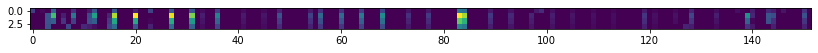

In [17]:
#Get A matrix and Alpha vector from simulations
#adding some amount of positive noise to A seems to mask the artifacts of least-squares problem solution
Alpha = np.ndarray(shape=(4,1))
Alpha[0] = alpha_1
Alpha[1] = alpha_2
Alpha[2] = alpha_3
Alpha[3] = alpha_4
A = np.ndarray(shape=(A_1.shape[0],4,4))
for i in range(A_1.shape[0]):
    A[i][0] = A_1[i]
    A[i][1] = A_2[i]
    A[i][2] = A_3[i]
    A[i][3] = A_4[i]
print("Alpha:")
print(Alpha)
print("A:")
print(A[0])
fig1, ax1 = plt.subplots(figsize=(14,4))
A_plot = np.ndarray(shape=(4,0))
for i in range(A.shape[0]):
    A_plot = np.concatenate((A_plot,A[i]),axis = 1)
ax1.imshow(A_plot)

In [18]:
#run SEIR simulation from estimated parameters

groups = 4
Ss = np.zeros((Days,groups))
Es = np.zeros((Days,groups))
Is = np.zeros((Days,groups))
Rs = np.zeros((Days,groups))
Ds = np.zeros((Days,groups))
CI = np.zeros((Days,groups))

for i in range(4):
    Ss[0][i]=S[ages[i]][0]            # initial susceptible populatioon
    Es[0][i]=E[ages[i]][0]                # initial exposed
    Is[0][i]=I[ages[i]][0]               # initial infected
    Rs[0][i]=R[ages[i]][0]
    Ds[0][i]=D[ages[i]][0]

segment = -1
for i in range(0,Days-1):
    N = sum(Ss[i])+sum(Es[i])+sum(Is[i])+sum(Rs[i])

    if(i%segment_size == 0):
        segment = segment+1
    for j in range(0,groups):

        Ss[i+1][j] = Ss[i][j] - sum(np.multiply(A[segment][j],Is[i])*Ss[i][j])/N
        Es[i+1][j] = Es[i][j] + sum(np.multiply(A[segment][j],Is[i])*Ss[i][j])/N - epsilon*Es[i][j]
        Is[i+1][j] = Is[i][j] + epsilon*Es[i][j] - (Alpha[j]+gamma)*Is[i][j]
        Rs[i+1][j] = Rs[i][j] + gamma*Is[i][j]
        Ds[i+1][j] = Ds[i][j] + Alpha[j]*Is[i][j]
        CI[i+1][j] = CI[i][j] + epsilon*Es[i][j]
        #dI[i] = epsilon*E[i]
        #dD[i] = D[i+1] - D[i]

S1 = np.zeros((Days,1))
E1 = np.zeros((Days,1))
I1 = np.zeros((Days,1))
R1 = np.zeros((Days,1))
D1 = np.zeros((Days,1))

for i in range(0,Days):
    S1[i] = sum(Ss[i])
    E1[i] = sum(Es[i])
    I1[i] = sum(Is[i])
    R1[i] = sum(Rs[i])
    D1[i] = sum(Ds[i])


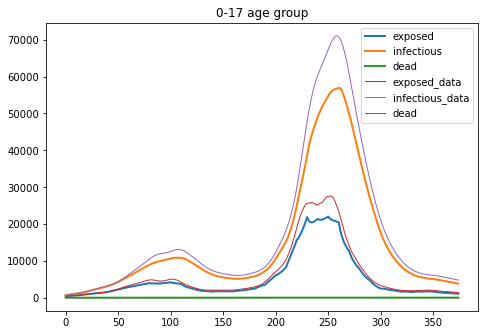

In [19]:
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
#ax.plot(Ss[:,0],lw=2,label='suceptible')
ax.plot(Es[:,0],lw=2,label='exposed')
ax.plot(Is[:,0],lw=2,label='infectious')
#ax.plot(Rs[:,0],lw=2,label='recovered')
ax.plot(Ds[:,0],lw=2,label='dead')
ax.plot(E[ages[0]],lw=1,label='exposed_data')
ax.plot(I[ages[0]],lw=1,label='infectious_data')
#ax.plot(R[ages[0]],lw=1,label='recovered_data')
ax.plot(D[ages[0]],lw=1,label='dead')
ax.set_title("0-17 age group")
#ax.set_ylabel(‘Price’,fontsize=20)
plt.legend(loc='upper right')

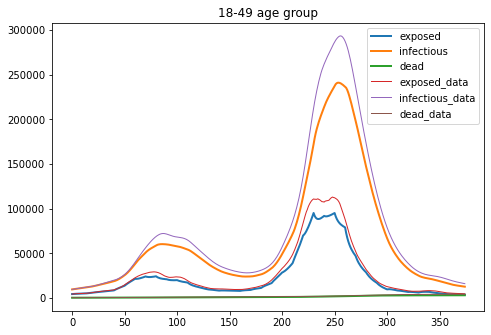

In [20]:

fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
#ax.plot(Ss[:,1],lw=2,label='suceptible')
ax.plot(Es[:,1],lw=2,label='exposed')
ax.plot(Is[:,1],lw=2,label='infectious')
#ax.plot(Rs[:,1],lw=2,label='recovered')
ax.plot(Ds[:,1],lw=2,label='dead')
ax.plot(E[ages[1]],lw=1,label='exposed_data')
ax.plot(I[ages[1]],lw=1,label='infectious_data')
#ax.plot(R[ages[1]],lw=1,label='recovered_data')
ax.plot(D[ages[1]],lw=1,label='dead_data')

ax.set_title("18-49 age group")
#ax.set_ylabel(‘Price’,fontsize=20)
plt.legend(loc='upper right')

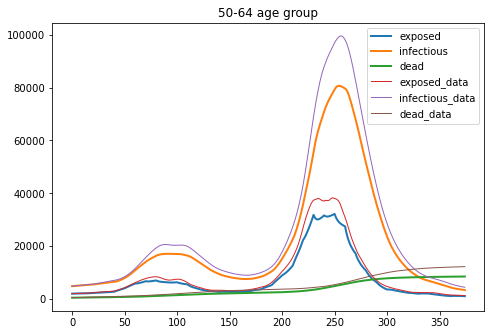

In [21]:

fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
#ax.plot(Ss[:,2],lw=2,label='suceptible')
ax.plot(Es[:,2],lw=2,label='exposed')
ax.plot(Is[:,2],lw=2,label='infectious')
#ax.plot(Rs[:,2],lw=2,label='recovered')
ax.plot(Ds[:,2],lw=2,label='dead')
#ax.plot(S[ages[2]],lw=1,label='suceptible_data')
ax.plot(E[ages[2]],lw=1,label='exposed_data')
ax.plot(I[ages[2]],lw=1,label='infectious_data')
#ax.plot(R[ages[2]],lw=1,label='recovered_data')
ax.plot(D[ages[2]],lw=1,label='dead_data')
ax.set_title("50-64 age group")
#ax.set_ylabel(‘Price’,fontsize=20)
plt.legend(loc='upper right')

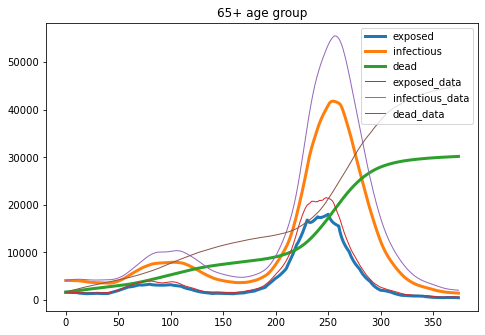

In [22]:
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
#ax.plot(Ss[:,3],lw=3,label='suceptible')
ax.plot(Es[:,3],lw=3,label='exposed')
ax.plot(Is[:,3],lw=3,label='infectious')
#ax.plot(Rs[:,3],lw=3,label='recovered')
ax.plot(Ds[:,3],lw=3,label='dead')

ax.plot(E[ages[3]],lw=1,label='exposed_data')
ax.plot(I[ages[3]],lw=1,label='infectious_data')
#ax.plot(R[ages[3]],lw=1,label='recovered_data')
ax.plot(D[ages[3]],lw=1,label='dead_data')
ax.set_title("65+ age group")
#ax.set_ylabel(‘Price’,fontsize=20)
plt.legend(loc='upper right')


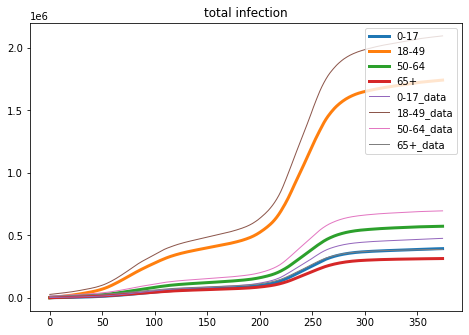

In [23]:
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
#ax.plot(Ss[:,3],lw=3,label='suceptible')
ax.plot(CI[:,0],lw=3,label=ages[0])
ax.plot(CI[:,1],lw=3,label=ages[1])
ax.plot(CI[:,2],lw=3,label=ages[2])
ax.plot(CI[:,3],lw=3,label=ages[3])

ax.plot(Inf[ages[0]],lw=1,label=ages[0]+'_data')
ax.plot(Inf[ages[1]],lw=1,label=ages[1]+'_data')
ax.plot(Inf[ages[2]],lw=1,label=ages[2]+'_data')
ax.plot(Inf[ages[3]],lw=1,label=ages[3]+'_data')
ax.set_title("total infection")
#ax.set_ylabel(‘Price’,fontsize=20)
plt.legend(loc='upper right')
